# Mogi Source Deformation modeling in Python

<font size= “5”>
The following description is taken from [this website](https://gscommunitycodes.usf.edu/geoscicommunitycodes/public/numeracy/numeracy_mogi/mogi.html).

In 1958, Kiyoo Mogi published a paper in which he described remarkable deformation of Sakurajima volcano during and following its 1914 eruption. He documented subsidence following the eruption of tens of centimeters up to 17 km from the volcano's vent. The pattern of subsidence was radially symmetric about a point near the location of the volcanic vent, so Mogi realized the pattern of deformation provided insight about the change in pressure beneath the volcano during the eruption.

His paper is well-known today primarily because he went on to develop a model to describe the change in pressure within the Earth necessary to explain the observed radial pattern of deformation. The model is elegant in its simplifying assumptions and useful because deformation associated with a variety of processes, such as subsidence due to groundwater withdrawal, or inflation of volcanoes prior to some volcanic eruptions.

The calculation presented in the following is more fully explained in:
Connor, C., 2022. Computing for Numeracy: Kiyoo Mogi and the nature of volcanoes, Numeracy, 15(1)
</font>

The following diagram shows the basics of the model. 
<div>
<img src="attachment:mogi.png" width="500"/>
</div>


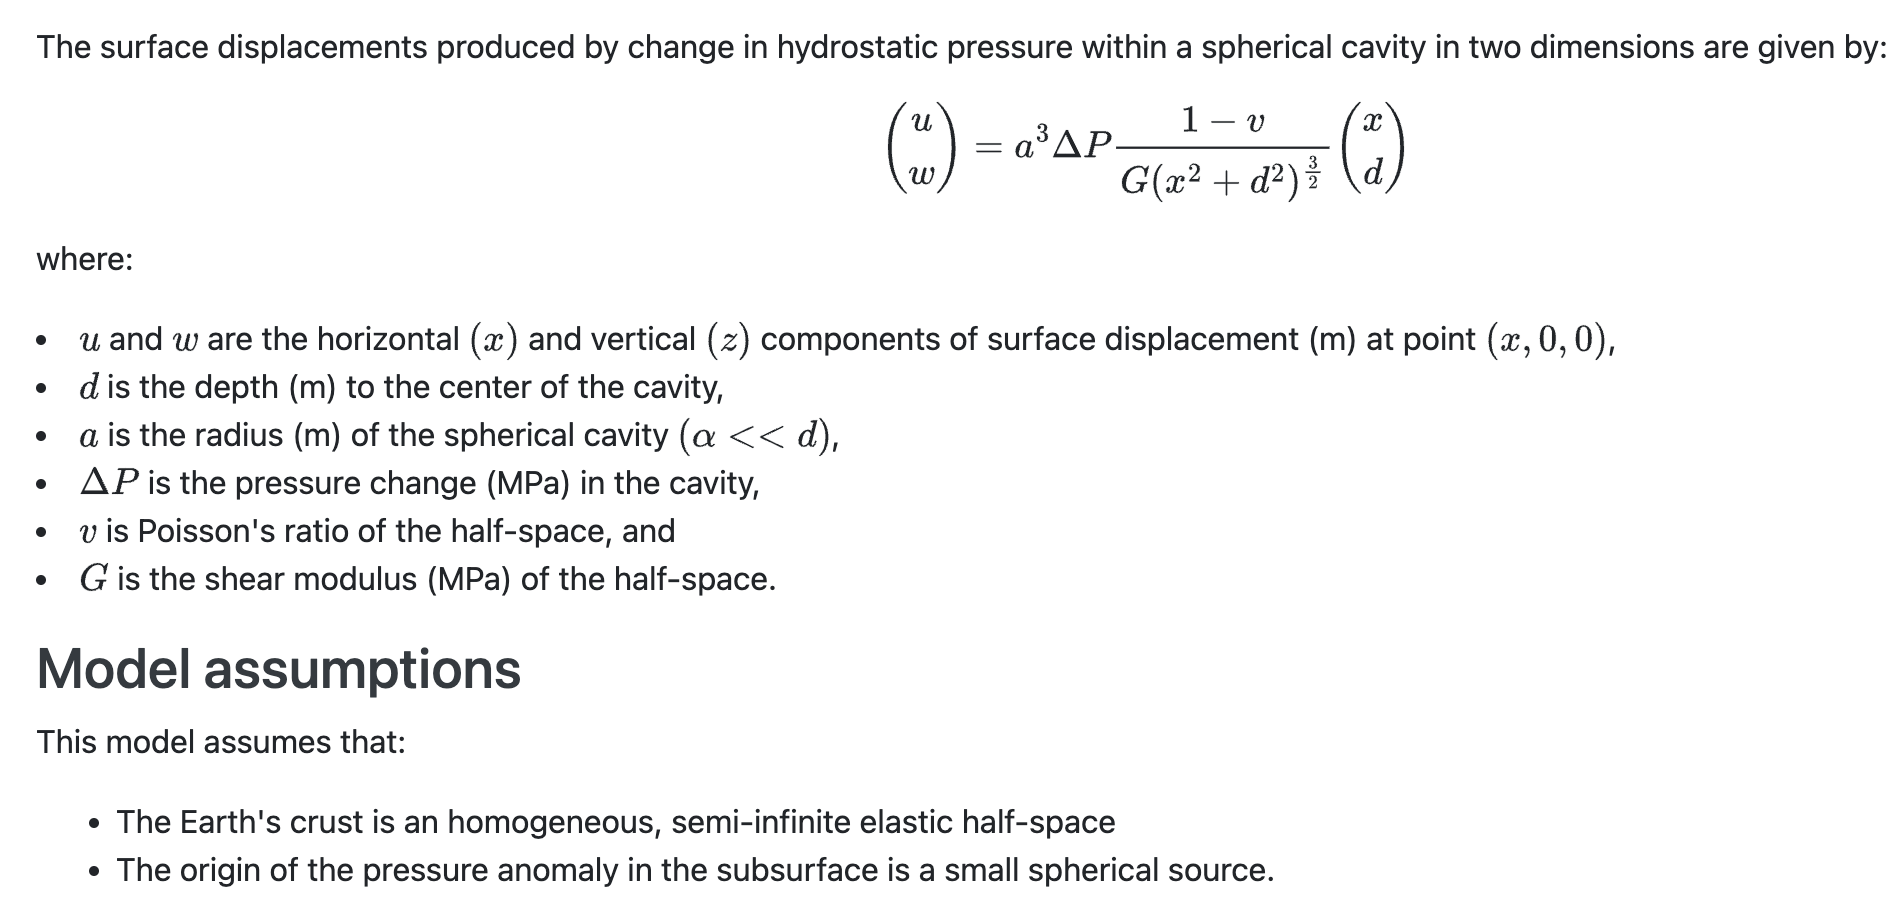

In [1]:
# We'll import a couple of libraries
import matplotlib.pyplot as plt
import numpy as np

We need to define functions that we will use to create the predicted displacements given some model parameters; i.e., a ''forward model''. 
This will allow us to later solve for parameters given some displacements.

The following codes are modified from https://github.com/scottyhq/cov9/tree/master

In [2]:
# =====================
# Helper functions
# =====================
def dP2dV(dP, a, mu=30e9):
    dV = (np.pi * dP * a**3) / mu
    return dV


def dV2dP(dV, a, mu=30e9):
    dP = (dV * mu) / (np.pi * a**3)
    return dP


def cart2pol(x1, x2):
    theta = np.arctan2(x2, x1)
    r = np.hypot(x2, x1)
    return theta, r


def pol2cart(theta, r):
    x1 = r * np.cos(theta)
    x2 = r * np.sin(theta)
    return x1, x2


def get_cart2los(incidence, heading):
    """
    Coefficients for projecting cartesian displacements into LOS vector
    """
    incidence = np.deg2rad(incidence)
    heading = np.deg2rad(heading)

    EW2los = np.sin(heading) * np.sin(incidence)
    NS2los = np.cos(heading) * np.sin(incidence)
    Z2los = -np.cos(incidence)

    cart2los = np.dstack([EW2los, NS2los, Z2los])

    return cart2los

In [ ]:
# These functions define the vertical and horizontal displacements for a Mogi source
def mogi(x, y, dV, d, xcenter=0, ycenter=0, G=3e5, nu=0.25):
    """
    Calculate the vertical displacement (m) at the surface due to a
    subsurface pressure source using Mogi's solution.

    Arguments:
        dV      - change in volume of the source
        x,y     - horizontal distance (m), radial from source
        a       - source radius (m), must be << d
        d       - source depth (m)
        xcenter - x-location of the point source
        ycenter - y-location of the point source
        g       - shear modulus (MPa), typically 3e5 or less
        nu      - Poisson's ratio (typically 0.25)

    Returns:
        Vertical and horizontal displacements from a Mogi source. Note that
        vertical is positive up, horizontal will follow your input coordinate
        system x

        ux - x-direction change
        uy - y-direction change
        uz - z-direction change
    """
    # Convert to surface cylindrical coordinates
    th, rho = cart2pol(x, y)
    R = np.hypot(d, rho)

    # Mogi displacement calculation
    C = ((1 - nu) / np.pi) * dV
    ur = C * rho / R**3
    uz = C * d / R**3

    ux, uy = pol2cart(th, ur)

    return np.array([ux, uy, uz])


def forward_dp(x, y, xcen=0, ycen=0, d=3e3, a=500, dP=100e6, mu=4e9, nu=0.25):
    """
    Same as "mogi" above except uses the change in pressure dP instead of
    change in volume dV.

    NOTE: dV = pi * dP * a**3 / mu

    981747.7 ~ 1e6
    """
    dV = np.pi * dP * a**3 / mu
    return mogi(x, y, dV, d, xcenter=xcen, ycenter=ycen, nu=nu)

In [4]:
# Parameters we will use
a = 2500.0  # source radius (m)
d = 10000.0  # source depth (m)
delta_p = -400.0  # excess pressure (MPa)
g = 30000.0  # rigidity of elastic half-space (MPa)

dV = np.pi * delta_p * (a**3) / g

In [5]:
dV / 1e9

-0.6544984694978735

In [6]:
# We need to setup some "stations"
x = np.arange(-5e4, 5e4, 100)
y = np.zeros_like(x)

In [7]:
ux, uy, uz = mogi(x, y, dV, d)

Text(0, 0.5, 'u/w')

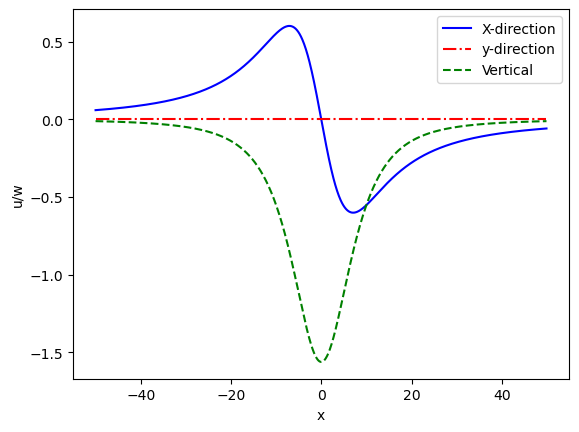

In [8]:
plt.plot(x / 1000, ux, '-b', label='X-direction')
plt.plot(x / 1000, uy, '-.r', label='y-direction')
plt.plot(x / 1000, uz, '--g', label='Vertical')
plt.legend()
plt.xlabel('x')
plt.ylabel('u/w')

In [9]:
# TODO: get some actual data to compare against